# Text mining 

We use the nltk (Natural Language Toolkit) library and other machine learning tools in Python.

In [1]:
import re, string

from pandas import read_csv, DataFrame, set_option
from pandas.api.types import is_object_dtype

from datetime import datetime
from numpy import array, c_

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings

In [3]:
font = {
    'family': 'arial',
    'size': 12,
    'weight': 'bold',
    'style': 'italic'
}

plt.rc('font', **font)

In [5]:
filterwarnings('ignore')

## About dataset 

Data of __news headlines__ published from 2015-01-01 to 2021-12-31. 

Agency Site: (http://www.abc.net.au)

In [7]:
# load the csv file using pandas
data = read_csv('input/abcnews-date-text_2015-01-01_2021-12-31.csv', dtype='object')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318703 entries, 0 to 318702
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   publish_date   318703 non-null  object
 1   headline_text  318703 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


In [9]:
print(
    f'Events in the world', 
    f'from {datetime.strptime(data.publish_date.values[0], '%Y%m%d').strftime('%Y-%m-%d')}', 
    f'to {datetime.strptime(data.publish_date.values[-1], '%Y%m%d').strftime('%Y-%m-%d')}'
)

Events in the world from 2015-01-01 to 2021-12-31


We extract events that occurred during the past four years

In [11]:
# data = data[
#     data['publish_date'].str.startswith('2021') | 
#     data['publish_date'].str.startswith('2020') | 
#     data['publish_date'].str.startswith('2019') |
#     data['publish_date'].str.startswith('2018') 
# ]

year = 2018
years= [f'{year}']
while year < 2021:
    year += 1
    years.append(f'{year}')

data = data[data['publish_date'].str.startswith(tuple(years))]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132328 entries, 186375 to 318702
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   publish_date   132328 non-null  object
 1   headline_text  132328 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [13]:
print(
    f'Events in the world', 
    f'from {datetime.strptime(data.publish_date.values[0], '%Y%m%d').strftime('%Y-%m-%d')}', 
    f'to {datetime.strptime(data.publish_date.values[-1], '%Y%m%d').strftime('%Y-%m-%d')}'
)

Events in the world from 2018-01-01 to 2021-12-31


In [15]:
# example dataset: a list of text documents
documents = data['headline_text']
documents

186375    10 us citizens 2 locals killed in costa rica p...
186376    african gang crime out of control in melbourne...
186377    a new generation of priests want to modernise ...
186378         anti government protests spread through iran
186379    astrology star signs vs astronomy zodiac const...
                                ...                        
318698    two aged care residents die as state records 2...
318699    victoria records 5;919 new cases and seven deaths
318700      wa delays adopting new close contact definition
318701    western ringtail possums found badly dehydrate...
318702    what makes you a close covid contact here are ...
Name: headline_text, Length: 132328, dtype: object

## Text data pre-processing

Text data pre-processing involves __cleaning and transforming text into a structured format__ so that it can be analyzed. The key steps involved in text data pre-processing:

1. __Text cleaning__
2. __Tokenization__
3. __Stop words removal__
4. __Lemmatization__
5. __Stemming__ 


### 1. Text cleaning

Text data can contain irrelevant information such as special characters (e.g., punctuation marks, symbols, etc.). For example, we observe that the document at row 318699 contains punctuation marks. Therefore, we can check each document to see if there are any unncessary punctuation marks.

In [20]:
# define a function to check if punctuation exists in a text
def contains_punct(text_data):
    return bool(re.search(r'[{}]'.format(re.escape(string.punctuation)), text_data))

documents[documents.apply(contains_punct)]

186396    hawkesbury river seaplane crash: recovery effo...
186417    new years celebrations a fantastic success; po...
186438                   the zodiac: your year in the stars
186442    we are fortunate: melbourne couple lucky not t...
186503    no evidence of fault with dhc 2 beaver; atsb says
                                ...                        
318683                january a significant challenge:foley
318685              nsw records 21;151 new case of covid 19
318697     to come away with gold with so much uncertainty;
318698    two aged care residents die as state records 2...
318699    victoria records 5;919 new cases and seven deaths
Name: headline_text, Length: 4071, dtype: object

We found 4071 documents tha contains punctuation marks. The next step is to remove each punctuation mark from each of these documents.

In [54]:
# define a function to remove punctuation
def remove_punct(text_data):
    # use re.sub() to replace punctuation with empty string
    return re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text_data)
# apply the function to every element in the DataFrame
documents = documents.apply(remove_punct)
documents

186375    10 us citizens 2 locals killed in costa rica p...
186376    african gang crime out of control in melbourne...
186377    a new generation of priests want to modernise ...
186378         anti government protests spread through iran
                                ...                        
318699     victoria records 5919 new cases and seven deaths
318700      wa delays adopting new close contact definition
318701    western ringtail possums found badly dehydrate...
318702    what makes you a close covid contact here are ...
Name: headline_text, Length: 132328, dtype: object

### 2. Tokenization

Firstly, it is necessary to __split the text into smaller (_tokens_)__. Let us use `word_tokenize` of `nltk.tokenize` to do this.

In [22]:
# for word tokenization
nltk.download('punkt')

# okenize and convert text to lowercase
tokens = documents.apply(lambda x: word_tokenize(str(x).lower()))
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\UTENTE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


186375    [10, us, citizens, 2, locals, killed, in, cost...
186376    [african, gang, crime, out, of, control, in, m...
186377    [a, new, generation, of, priests, want, to, mo...
186378    [anti, government, protests, spread, through, ...
186379    [astrology, star, signs, vs, astronomy, zodiac...
                                ...                        
318698    [two, aged, care, residents, die, as, state, r...
318699    [victoria, records, 5, ;, 919, new, cases, and...
318700    [wa, delays, adopting, new, close, contact, de...
318701    [western, ringtail, possums, found, badly, deh...
318702    [what, makes, you, a, close, covid, contact, h...
Name: headline_text, Length: 132328, dtype: object

### 3. Stopwords removal

Stopwords are common terms (e.g., "_the_", "_of_", "_to_", etc.) that don’t contribute meaningful information to analysis. These __stopwords are removed__ from the text. The method `stopwords.words('english')` provides a list of common english stopwords. The list comprehension filters out any word that is found in the stop_words set.

In [24]:
# for stopwords
nltk.download('stopwords')

# get the list of English stopwords
stop_words = set(stopwords.words('english'))
# remove stopwords
filtered_tokens = tokens.apply(lambda x: [word for word in x if word not in stop_words])
filtered_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UTENTE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


186375    [10, us, citizens, 2, locals, killed, costa, r...
186376    [african, gang, crime, control, melbourne, min...
186377    [new, generation, priests, want, modernise, ch...
186378           [anti, government, protests, spread, iran]
186379    [astrology, star, signs, vs, astronomy, zodiac...
                                ...                        
318698    [two, aged, care, residents, die, state, recor...
318699    [victoria, records, 5, ;, 919, new, cases, sev...
318700    [wa, delays, adopting, new, close, contact, de...
318701    [western, ringtail, possums, found, badly, deh...
318702           [makes, close, covid, contact, new, rules]
Name: headline_text, Length: 132328, dtype: object

### 4. Lemmatization

Lemmatization involves __reducing a term to its dictionary form__ (e.g., "_residents_" becomes "_resident_"). The class `WordNetLemmatizer` from the nltk.stem is commonly used to perform lemmatization. 

In [26]:
# for lemmatization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmatized_tokens = filtered_tokens.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
lemmatized_tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\UTENTE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


186375    [10, u, citizen, 2, local, killed, costa, rica...
186376    [african, gang, crime, control, melbourne, min...
186377    [new, generation, priest, want, modernise, chu...
186378            [anti, government, protest, spread, iran]
186379    [astrology, star, sign, v, astronomy, zodiac, ...
                                ...                        
318698    [two, aged, care, resident, die, state, record...
318699    [victoria, record, 5, ;, 919, new, case, seven...
318700    [wa, delay, adopting, new, close, contact, def...
318701    [western, ringtail, possum, found, badly, dehy...
318702             [make, close, covid, contact, new, rule]
Name: headline_text, Length: 132328, dtype: object

### 5. Stemming

Stemming __reduces terms to their root form__ by stripping suffixes (e.g., "_government_" becomes "_govern_"). The class `PorterStemmer` from from the nltk.stem uses a series of heuristic rules to improve stemming, and while it works well for many common words, it may not handle some edge cases perfectly.

In [28]:
stemmer = PorterStemmer()
stemmed_tokens = lemmatized_tokens.apply(lambda x: [stemmer.stem(word) for word in x])
stemmed_tokens

186375    [10, u, citizen, 2, local, kill, costa, rica, ...
186376    [african, gang, crime, control, melbourn, mini...
186377         [new, gener, priest, want, modernis, church]
186378                [anti, govern, protest, spread, iran]
186379    [astrolog, star, sign, v, astronomi, zodiac, c...
                                ...                        
318698    [two, age, care, resid, die, state, record, 2,...
318699    [victoria, record, 5, ;, 919, new, case, seven...
318700     [wa, delay, adopt, new, close, contact, definit]
318701    [western, ringtail, possum, found, badli, dehy...
318702             [make, close, covid, contact, new, rule]
Name: headline_text, Length: 132328, dtype: object

## Term frequency distribution

We can plot a 2-D graph with words on the x-axis and their counts on the y-axis to visualize the word frequency distribution. We use use the `nltk.FreqDist` class, which computes the frequency distribution of tokens. 

The series of the stemmed tokens contains lists of tokens for each document. We use a list comprehension to flatten all token lists into a single list `all_tokens`.

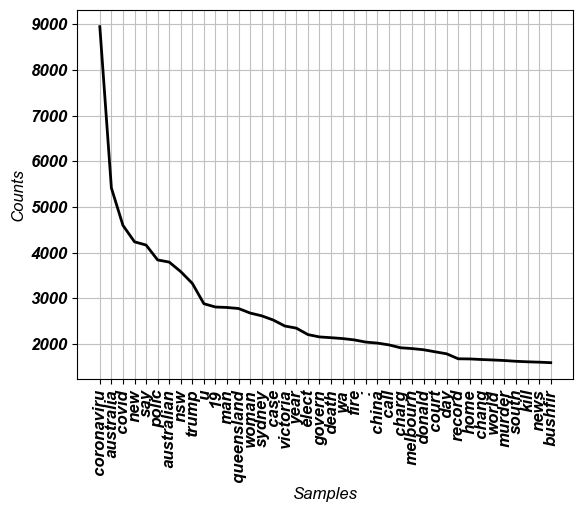

In [30]:
# flatten the token list for the entire dataset
all_tokens = [token for tokens_list in stemmed_tokens for token in tokens_list]
fdist = FreqDist(all_tokens)

# show top 40 most common tokens
fdist.plot(40, cumulative=False, c='k');  

## TF-IDF calculation

To calculate the TF-IDF statistic (Term Frequency-Inverse Document Frequency) we use `TfidfVectorizer` class from the `sklearn.feature_extraction.text` module of scikit-learn. Here's the steps to do it:

1. Initialize TfidfVectorizer
2. Fit and transform the data
3. Display the Result


### 1. TfidfVectorizer

`TfidfVectorizer` computes the TF-IDF score for each term in the provided documents. We set `max_features=20` to limit the output to the 20 most important terms based on their TF-IDF scores.

In [32]:
# compute TF-IDF using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=20)
vectorizer

TfidfVectorizer(max_features=20)

### 2. Fit and transform the data

The `.fit_transform()` method fits the vectorizer to the input text and then transforms the text into a TF-IDF matrix.

In [34]:
tfidf_matrix = vectorizer.fit_transform(all_tokens)
display(tfidf_matrix)
print('\n', tfidf_matrix.toarray())

<854558x20 sparse matrix of type '<class 'numpy.float64'>'
	with 69345 stored elements in Compressed Sparse Row format>


 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


The resulting tfidf_matrix is a sparse matrix and represents the TF-IDF values for each word in each document.

After transforming, we can view the resulting TF-IDF matrix, tipically in a pandas DataFrame for easier viewing and understanding, where rows represent documents and columns represent the terms/words.

In [36]:
set_option('display.max_rows', 8)  
set_option('display.max_columns', 8)  

# convert the TF-IDF matrix to a DataFrame 
tfidf_df = DataFrame(
    tfidf_matrix.toarray(), 
    columns=vectorizer.get_feature_names_out()
)
print(tfidf_df)

         19  australia  australian  case  ...  trump  victoria  woman  year
0       0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0
1       0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0
2       0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0
3       0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0
...     ...        ...         ...   ...  ...    ...       ...    ...   ...
854554  0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0
854555  0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0
854556  0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0
854557  0.0        0.0         0.0   0.0  ...    0.0       0.0    0.0   0.0

[854558 rows x 20 columns]


### 3. Display the Result 

To get the sum of the TF-IDF scores for each term across all documents in tfidf_df dataframe, we can use the `sum()` function, specifying the `axis=0 argument`. This will sum the values column-wise, giving the total TF-IDF score for each term across all documents. The resulting series is then reconverted into a DataFrame sorting by the first column in descending order to prioritize words with the highest TF-IDF scores. The method `reset_index()` is used to reset the index after sorting. Lastly, the columns are renamed.

In [38]:
term_scores_df = tfidf_df.sum(axis=0) \
    .to_frame() \
    .sort_values(by=0, ascending=False) \
    .reset_index() \
    .rename(columns={'index': 'term', 0: 'tfidf'})
print(term_scores_df)

          term   tfidf
0   coronaviru  8949.0
1    australia  5416.0
2        covid  4597.0
3          new  4237.0
..         ...     ...
16        year  2346.0
17       elect  2205.0
18      govern  2154.0
19       death  2137.0

[20 rows x 2 columns]


Here's the top 20 words with highest tf-idf values in this collection of documents.

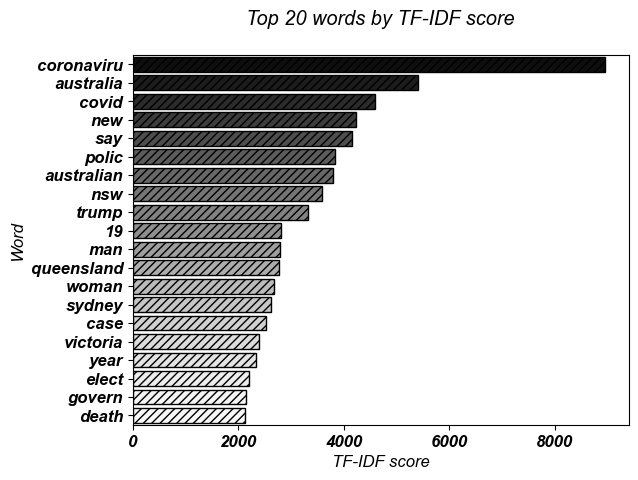

In [40]:
# visualize the top 20 words using a bar plot
sns.barplot(
    data=term_scores_df.head(20), 
    x='tfidf', y='term', 
    # color='w', 
    edgecolor='k', palette='Greys_r',
    hatch='////', 
)
plt.title('Top 20 words by TF-IDF score\n')
plt.xlabel('TF-IDF score')
plt.ylabel('Word');

The top 3 terms with the highest TF-IDF scores are "_coronavirus_", "_australia_", and "_covid_". These terms suggest that the dataset is strongly focused on the COVID-19 pandemic, particularly in the context of Australia. Terms such as "_elect_", "_govern_", and "_year_" suggest that the dataset might also touch on political or governance-related themes, possibly discussing elections, government responses.

## Lda implementation

To implement Latent Dirichlet Allocation (LDA) using scikit-learn, you can use the `LatentDirichletAllocation` class from `sklearn.decomposition`. Here's the steps to implement it:

1. Initialize CountVectorizer 
2. Fit the LDA model
3. Display topics
4. Topic distribution for document

### 1. Initialize CountVectorizer 

The class `CountVectorizer` from the `sklearn.feature_extraction.text` module is used to convert text data into a Bag-of-Words (BoW) matrix, and we exclude common stopwords using `stop_words='english'`.

In [42]:
# step 1: vectorize the text data and
# remove common English stop words
vectorizer = CountVectorizer(stop_words='english')  
X = vectorizer.fit_transform(documents)
display(X)
print('\n', X.toarray())

<132328x45409 sparse matrix of type '<class 'numpy.int64'>'
	with 814806 stored elements in Compressed Sparse Row format>


 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


The BoW representation often results in a sparse matrix, where sparsity due:

- <u>high dimensionality</u>: each word in the vocabulary corresponds to a column in the matrix, if the vocabulary contains more several unique words, the matrix will have many columns;
- <u>mostly zero cells</u>: this is because, in a given document, only a small subset of the vocabulary (words) will appear. The rest of the vocabulary will not be present in that document, leading to zero cells in those columns for that document.

### 2. Fit the LDA model 

We use the class `LatentDirichletAllocation` from `sklearn.decomposition` to fit the model and extract topics. We define the LatentDirichletAllocation model with `n_components=2`, meaning the model will attempt to discover 2 topics. 

We then fit the LDA model on the document-term matrix (X). This learns the topics from the data.

In [44]:
# step 2: fit the LDA model
n_topics = 2  # number of topics 
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=2, random_state=42)

### 3. Display topics 

After training, display the topics and the words associated with each topic. We print the top n words (e.g. n=8) associated with each topic using `lda.components_`. This gives us the most important terms for each topic.

In [46]:
# Step 3: display the topics
n_top_words = 8  # Number of top words to display per topic
print(f"Top {n_top_words} words per topic:")
feature_names = array(vectorizer.get_feature_names_out())

for topic_idx, topic in enumerate(lda.components_):
    print(
        f"Topic #{topic_idx+1}.",
        " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    )

Top 8 words per topic:
Topic #1. coronavirus covid australia new trump australian 19 says
Topic #2. police man government court death murder nt nsw


### 4. Topic distribution for document 

Then, we can check how the topics are distributed across specific documents with `lda.transform()`. This shows the proportion of each topic for a given document.

In [48]:
doc_topic_dist = lda.transform(X)

We create a DataFrame that combines the original documents with their topic distribution. The idea is to display the document text alongside the distribution of topics across those documents, i.e., how much each document is associated with each topic.

In [58]:
topic_df = DataFrame(
    c_[documents, doc_topic_dist], 
    columns=["Document"] + [f"Topic #{i+1}" for i in range(n_topics)]
)
topic_df.index = range(1, len(topic_df) + 1)
print(topic_df)

                                                 Document  Topic #1  Topic #2
1       10 us citizens 2 locals killed in costa rica p...  0.468032  0.531968
2       african gang crime out of control in melbourne...  0.885353  0.114647
3       a new generation of priests want to modernise ...  0.604663  0.395337
4            anti government protests spread through iran  0.678072  0.321928
...                                                   ...       ...       ...
132325   victoria records 5919 new cases and seven deaths   0.93383   0.06617
132326    wa delays adopting new close contact definition  0.742842  0.257158
132327  western ringtail possums found badly dehydrate...  0.379159  0.620841
132328  what makes you a close covid contact here are ...  0.922198  0.077802

[132328 rows x 3 columns]


## Observations and conclusion:

- __Topic #1 (dominant)__. Many documents show a clear dominance of Topic #1, with high values like 0.885353 (document 2), 0.93383 (document 132325), and 0.922198 (document 132328). This suggests that Topic #1 is frequently the dominant topic in the dataset.
- __Topic #2__. Documents with a higher probability for Topic #2 include headlines such as "_western ringtail possums found badly dehydrate..._" (0.620841 for Topic #2), which indicates a focus on a different theme, possibly environmental or wildlife-related issues.

The data set reguard a variety of news topics, with a strong focus on public health and governance, but also other societal issues like crime, environmental concerns.